In [8]:
import math

import numpy as np
import torch
import torch.nn as nn
import torchvision

from lightly.data import LightlyDataset
from lightly.loss import NegativeCosineSimilarity
from lightly.models.modules.heads import SimSiamPredictionHead, SimSiamProjectionHead
from lightly.transforms import SimCLRTransform, utils
from tqdm import tqdm

In [9]:
num_workers = 4
batch_size = 32
seed = 1
epochs = 50
input_size = 224
# dimension of the embeddings
num_ftrs = 512
# dimension of the output of the prediction and projection heads
out_dim = proj_hidden_dim = 512
# the prediction head uses a bottleneck architecture
pred_hidden_dim = 128

In [10]:
# seed torch and numpy
torch.manual_seed(0)
np.random.seed(0)

# set the path to the dataset
path_to_data = "/home/akansh-i2sc/Desktop/Study/HLCV/SeCo_dataset/seco_100k/jpeg_40k/"

In [34]:
# define the augmentations for self-supervised learning
transform = SimCLRTransform(
    input_size=input_size,
    # require invariance to flips and rotations
    hf_prob=0.5,
    vf_prob=0.5,
    rr_prob=0.5,
    # satellite images are all taken from the same height
    # so we use only slight random cropping
    min_scale=0.5,
    # use a weak color jitter for invariance w.r.t small color changes
    cj_prob=0.2,
    cj_bright=0.1,
    cj_contrast=0.1,
    cj_hue=0.1,
    cj_sat=0.1,
)

# create a lightly dataset for training with augmentations
dataset_train_simsiam = LightlyDataset(input_dir=path_to_data, transform=transform)

# create a dataloader for training
dataloader_train_simsiam = torch.utils.data.DataLoader(
    dataset_train_simsiam,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers,
)

# create a torchvision transformation for embedding the dataset after training
# here, we resize the images to match the input size during training and apply
# a normalization of the color channel based on statistics from imagenet
test_transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize((input_size, input_size)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean=utils.IMAGENET_NORMALIZE["mean"],
            std=utils.IMAGENET_NORMALIZE["std"],
        ),
    ]
)

# create a lightly dataset for embedding
dataset_test = LightlyDataset(input_dir=path_to_data, transform=test_transforms)

# create a dataloader for embedding
dataloader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers,
)

In [12]:
class SimSiam(nn.Module):
    def __init__(self, backbone, num_ftrs, proj_hidden_dim, pred_hidden_dim, out_dim):
        super().__init__()
        self.backbone = backbone
        self.projection_head = SimSiamProjectionHead(num_ftrs, proj_hidden_dim, out_dim)
        self.prediction_head = SimSiamPredictionHead(out_dim, pred_hidden_dim, out_dim)

    def forward(self, x):
        # get representations
        f = self.backbone(x).flatten(start_dim=1)
        # get projections
        z = self.projection_head(f)
        # get predictions
        p = self.prediction_head(z)
        # stop gradient
        z = z.detach()
        return z, p


# we use a pretrained resnet for this tutorial to speed
# up training time but you can also train one from scratch
resnet = torchvision.models.resnet18()
backbone = nn.Sequential(*list(resnet.children())[:-1])
model = SimSiam(backbone, num_ftrs, proj_hidden_dim, pred_hidden_dim, out_dim)

SimSiam uses a symmetric negative cosine similarity loss and does therefore not require any negative samples. We build a criterion and an optimizer.

In [13]:
# SimSiam uses a symmetric negative cosine similarity loss
criterion = NegativeCosineSimilarity()

# scale the learning rate
lr = 0.05 * batch_size / 256
# use SGD with momentum and weight decay
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)

In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

avg_loss = 0.0
avg_output_std = 0.0
for e in range(epochs):
    for (x0, x1), _, _ in tqdm(dataloader_train_simsiam):
        # move images to the gpu
        x0 = x0.to(device)
        x1 = x1.to(device)

        # run the model on both transforms of the images
        # we get projections (z0 and z1) and
        # predictions (p0 and p1) as output
        z0, p0 = model(x0)
        z1, p1 = model(x1)

        # apply the symmetric negative cosine similarity
        # and run backpropagation
        loss = 0.5 * (criterion(z0, p1) + criterion(z1, p0))
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        # calculate the per-dimension standard deviation of the outputs
        # we can use this later to check whether the embeddings are collapsing
        output = p0.detach()
        output = torch.nn.functional.normalize(output, dim=1)

        output_std = torch.std(output, 0)
        output_std = output_std.mean()

        # use moving averages to track the loss and standard deviation
        w = 0.9
        avg_loss = w * avg_loss + (1 - w) * loss.item()
        avg_output_std = w * avg_output_std + (1 - w) * output_std.item()

    # the level of collapse is large if the standard deviation of the l2
    # normalized output is much smaller than 1 / sqrt(dim)
    collapse_level = max(0.0, 1 - math.sqrt(out_dim) * avg_output_std)
    # print intermediate results
    print(
        f"[Epoch {e:3d}] "
        f"Loss = {avg_loss:.2f} | "
        f"Collapse Level: {collapse_level:.2f} / 1.00"
    )

100%|██████████| 625/625 [00:55<00:00, 11.20it/s]


[Epoch   0] Loss = -0.94 | Collapse Level: 0.10 / 1.00


100%|██████████| 625/625 [00:55<00:00, 11.17it/s]


[Epoch   1] Loss = -0.95 | Collapse Level: 0.08 / 1.00


100%|██████████| 625/625 [00:56<00:00, 11.10it/s]


[Epoch   2] Loss = -0.96 | Collapse Level: 0.08 / 1.00


100%|██████████| 625/625 [00:56<00:00, 11.07it/s]


[Epoch   3] Loss = -0.97 | Collapse Level: 0.08 / 1.00


100%|██████████| 625/625 [00:56<00:00, 11.08it/s]


[Epoch   4] Loss = -0.97 | Collapse Level: 0.08 / 1.00


100%|██████████| 625/625 [00:56<00:00, 11.04it/s]


[Epoch   5] Loss = -0.97 | Collapse Level: 0.08 / 1.00


100%|██████████| 625/625 [00:56<00:00, 11.05it/s]


[Epoch   6] Loss = -0.97 | Collapse Level: 0.08 / 1.00


100%|██████████| 625/625 [00:56<00:00, 11.07it/s]


[Epoch   7] Loss = -0.97 | Collapse Level: 0.08 / 1.00


100%|██████████| 625/625 [00:56<00:00, 11.08it/s]


[Epoch   8] Loss = -0.97 | Collapse Level: 0.07 / 1.00


100%|██████████| 625/625 [00:56<00:00, 11.07it/s]


[Epoch   9] Loss = -0.97 | Collapse Level: 0.07 / 1.00


100%|██████████| 625/625 [00:56<00:00, 11.09it/s]


[Epoch  10] Loss = -0.97 | Collapse Level: 0.07 / 1.00


100%|██████████| 625/625 [00:56<00:00, 11.12it/s]


[Epoch  11] Loss = -0.97 | Collapse Level: 0.07 / 1.00


100%|██████████| 625/625 [00:56<00:00, 11.10it/s]


[Epoch  12] Loss = -0.97 | Collapse Level: 0.07 / 1.00


100%|██████████| 625/625 [00:56<00:00, 11.09it/s]


[Epoch  13] Loss = -0.97 | Collapse Level: 0.06 / 1.00


100%|██████████| 625/625 [00:56<00:00, 11.06it/s]


[Epoch  14] Loss = -0.97 | Collapse Level: 0.07 / 1.00


100%|██████████| 625/625 [00:56<00:00, 11.05it/s]


[Epoch  15] Loss = -0.97 | Collapse Level: 0.08 / 1.00


100%|██████████| 625/625 [00:56<00:00, 11.06it/s]


[Epoch  16] Loss = -0.97 | Collapse Level: 0.07 / 1.00


100%|██████████| 625/625 [00:56<00:00, 11.06it/s]


[Epoch  17] Loss = -0.97 | Collapse Level: 0.07 / 1.00


100%|██████████| 625/625 [00:56<00:00, 11.06it/s]


[Epoch  18] Loss = -0.97 | Collapse Level: 0.07 / 1.00


100%|██████████| 625/625 [00:56<00:00, 11.06it/s]


[Epoch  19] Loss = -0.97 | Collapse Level: 0.08 / 1.00


100%|██████████| 625/625 [00:56<00:00, 11.07it/s]


[Epoch  20] Loss = -0.97 | Collapse Level: 0.09 / 1.00


100%|██████████| 625/625 [00:56<00:00, 11.08it/s]


[Epoch  21] Loss = -0.97 | Collapse Level: 0.08 / 1.00


100%|██████████| 625/625 [00:56<00:00, 11.05it/s]


[Epoch  22] Loss = -0.97 | Collapse Level: 0.10 / 1.00


100%|██████████| 625/625 [00:56<00:00, 11.06it/s]


[Epoch  23] Loss = -0.97 | Collapse Level: 0.09 / 1.00


100%|██████████| 625/625 [00:56<00:00, 11.07it/s]


[Epoch  24] Loss = -0.97 | Collapse Level: 0.08 / 1.00


100%|██████████| 625/625 [00:56<00:00, 11.08it/s]


[Epoch  25] Loss = -0.96 | Collapse Level: 0.10 / 1.00


100%|██████████| 625/625 [00:56<00:00, 11.07it/s]


[Epoch  26] Loss = -0.96 | Collapse Level: 0.10 / 1.00


100%|██████████| 625/625 [00:56<00:00, 11.02it/s]


[Epoch  27] Loss = -0.97 | Collapse Level: 0.10 / 1.00


100%|██████████| 625/625 [00:56<00:00, 11.07it/s]


[Epoch  28] Loss = -0.96 | Collapse Level: 0.09 / 1.00


100%|██████████| 625/625 [00:56<00:00, 11.09it/s]


[Epoch  29] Loss = -0.96 | Collapse Level: 0.09 / 1.00


100%|██████████| 625/625 [00:56<00:00, 11.06it/s]


[Epoch  30] Loss = -0.96 | Collapse Level: 0.09 / 1.00


100%|██████████| 625/625 [00:56<00:00, 11.07it/s]


[Epoch  31] Loss = -0.97 | Collapse Level: 0.12 / 1.00


100%|██████████| 625/625 [00:56<00:00, 11.06it/s]


[Epoch  32] Loss = -0.95 | Collapse Level: 0.13 / 1.00


100%|██████████| 625/625 [00:56<00:00, 11.08it/s]


[Epoch  33] Loss = -0.96 | Collapse Level: 0.12 / 1.00


100%|██████████| 625/625 [00:56<00:00, 11.07it/s]


[Epoch  34] Loss = -0.96 | Collapse Level: 0.12 / 1.00


100%|██████████| 625/625 [00:56<00:00, 11.03it/s]


[Epoch  35] Loss = -0.97 | Collapse Level: 0.12 / 1.00


100%|██████████| 625/625 [00:56<00:00, 11.03it/s]


[Epoch  36] Loss = -0.97 | Collapse Level: 0.13 / 1.00


100%|██████████| 625/625 [00:56<00:00, 11.03it/s]


[Epoch  37] Loss = -0.96 | Collapse Level: 0.13 / 1.00


100%|██████████| 625/625 [00:56<00:00, 11.03it/s]


[Epoch  38] Loss = -0.97 | Collapse Level: 0.13 / 1.00


100%|██████████| 625/625 [00:56<00:00, 10.99it/s]


[Epoch  39] Loss = -0.96 | Collapse Level: 0.13 / 1.00


100%|██████████| 625/625 [00:56<00:00, 11.01it/s]


[Epoch  40] Loss = -0.96 | Collapse Level: 0.12 / 1.00


100%|██████████| 625/625 [00:56<00:00, 10.98it/s]


[Epoch  41] Loss = -0.96 | Collapse Level: 0.14 / 1.00


100%|██████████| 625/625 [00:56<00:00, 11.02it/s]


[Epoch  42] Loss = -0.96 | Collapse Level: 0.14 / 1.00


100%|██████████| 625/625 [00:56<00:00, 10.97it/s]


[Epoch  43] Loss = -0.95 | Collapse Level: 0.13 / 1.00


100%|██████████| 625/625 [00:57<00:00, 10.93it/s]


[Epoch  44] Loss = -0.96 | Collapse Level: 0.15 / 1.00


100%|██████████| 625/625 [00:56<00:00, 10.98it/s]


[Epoch  45] Loss = -0.94 | Collapse Level: 0.11 / 1.00


100%|██████████| 625/625 [00:56<00:00, 11.03it/s]


[Epoch  46] Loss = -0.96 | Collapse Level: 0.15 / 1.00


100%|██████████| 625/625 [00:56<00:00, 11.04it/s]


[Epoch  47] Loss = -0.96 | Collapse Level: 0.13 / 1.00


100%|██████████| 625/625 [00:56<00:00, 11.05it/s]


[Epoch  48] Loss = -0.96 | Collapse Level: 0.14 / 1.00


100%|██████████| 625/625 [00:56<00:00, 11.04it/s]

[Epoch  49] Loss = -0.97 | Collapse Level: 0.14 / 1.00


In [56]:
pretrained_resnet_backbone = model.backbone
state_dict = {"resnet18_parameters": pretrained_resnet_backbone.state_dict()}
torch.save(state_dict, "/home/akansh-i2sc/Desktop/Study/HLCV/Why-Self-Supervision-in-Time/src/models/simsam_20k_30e_resnet_18.pth")

#### SIM-SAM Embedings

In [ ]:
# for plotting
import os

import matplotlib.offsetbox as osb
import matplotlib.pyplot as plt

# for resizing images to thumbnails
import torchvision.transforms.functional as functional
from matplotlib import rcParams as rcp
from PIL import Image

# for clustering and 2d representations
from sklearn import random_projection

In [37]:
embeddings = []
filenames = []

# disable gradients for faster calculations
model.eval()
with torch.no_grad():
    for i, (x, _, fnames) in enumerate(dataloader_test):
        # move the images to the gpu
        x = x.to(device)
        # embed the images with the pre-trained backbone
        y = model.backbone(x).flatten(start_dim=1)
        # store the embeddings and filenames in lists
        embeddings.append(y)
        filenames = filenames + list(fnames)

# concatenate the embeddings and convert to numpy
embeddings = torch.cat(embeddings, dim=0)
embeddings = embeddings.cpu().numpy()

In [40]:
projection = random_projection.GaussianRandomProjection(n_components=2)
embeddings_2d = projection.fit_transform(embeddings)
# normalize the embeddings to fit in the [0, 1] square
M = np.max(embeddings_2d, axis=0)
m = np.min(embeddings_2d, axis=0)
embeddings_2d = (embeddings_2d - m) / (M - m)

40000

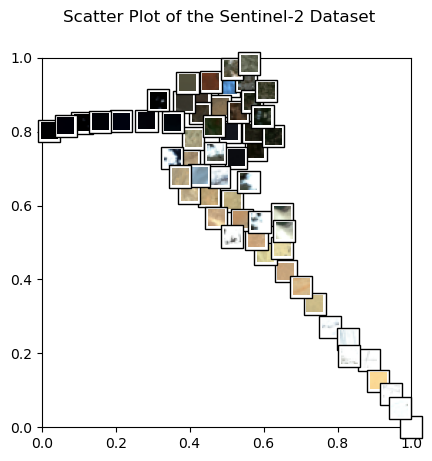

In [41]:
def get_scatter_plot_with_thumbnails():
    """Creates a scatter plot with image overlays."""
    # initialize empty figure and add subplot
    fig = plt.figure()
    fig.suptitle("Scatter Plot of the Sentinel-2 Dataset")
    ax = fig.add_subplot(1, 1, 1)
    # shuffle images and find out which images to show
    shown_images_idx = []
    shown_images = np.array([[1.0, 1.0]])
    iterator = [i for i in range(embeddings_2d.shape[0])]
    np.random.shuffle(iterator)
    for i in iterator:
        # only show image if it is sufficiently far away from the others
        dist = np.sum((embeddings_2d[i] - shown_images) ** 2, 1)
        if np.min(dist) < 2e-3:
            continue
        shown_images = np.r_[shown_images, [embeddings_2d[i]]]
        shown_images_idx.append(i)

    # plot image overlays
    for idx in shown_images_idx:
        thumbnail_size = int(rcp["figure.figsize"][0] * 2.0)
        path = os.path.join(path_to_data, filenames[idx])
        img = Image.open(path)
        img = functional.resize(img, thumbnail_size)
        img = np.array(img)
        img_box = osb.AnnotationBbox(
            osb.OffsetImage(img, cmap=plt.cm.gray_r),
            embeddings_2d[idx],
            pad=0.2,
        )
        ax.add_artist(img_box)

    # set aspect ratio
    ratio = 1.0 / ax.get_data_ratio()
    ax.set_aspect(ratio, adjustable="box")


# get a scatter plot with thumbnail overlays
get_scatter_plot_with_thumbnails()

In [53]:
#select random 5 example from list a
import glob
a = glob.glob("/home/akansh-i2sc/Desktop/Study/HLCV/SeCo_dataset/seco_100k/jpeg_40k/*.jpg")
import random
random.seed(1)
example_images = random.sample(a,5)
print(example_images)
example_images = ['11413.jpg', '11414.jpg', '11415.jpg', '11416.jpg', '11417.jpg']

['/home/akansh-i2sc/Desktop/Study/HLCV/SeCo_dataset/seco_100k/jpeg_40k/11413.jpg', '/home/akansh-i2sc/Desktop/Study/HLCV/SeCo_dataset/seco_100k/jpeg_40k/temp18941.jpg', '/home/akansh-i2sc/Desktop/Study/HLCV/SeCo_dataset/seco_100k/jpeg_40k/918.jpg', '/home/akansh-i2sc/Desktop/Study/HLCV/SeCo_dataset/seco_100k/jpeg_40k/temp10556.jpg', '/home/akansh-i2sc/Desktop/Study/HLCV/SeCo_dataset/seco_100k/jpeg_40k/temp19952.jpg']


In [57]:
def get_image_as_np_array(filename: str):
    """Loads the image with filename and returns it as a numpy array."""
    img = Image.open(filename)
    return np.asarray(img)

def get_image_as_np_array_with_frame(filename: str, w: int = 5):
    """Returns an image as a numpy array with a black frame of width w."""
    img = get_image_as_np_array(filename)
    ny, nx, _ = img.shape
    # create an empty image with padding for the frame
    framed_img = np.zeros((w + ny + w, w + nx + w, 3))
    framed_img = framed_img.astype(np.uint8)
    # put the original image in the middle of the new one
    framed_img[w:-w, w:-w] = img
    return framed_img

def plot_nearest_neighbors_3x3(example_image: str, i: int):
    """Plots the example image and its eight nearest neighbors."""
    n_subplots = 9
    # initialize empty figure
    fig = plt.figure()
    fig.suptitle(f"Nearest Neighbor Plot {i + 1}")
    #
    example_idx = filenames.index(example_image)
    # get distances to the cluster center
    distances = embeddings - embeddings[example_idx]
    distances = np.power(distances, 2).sum(-1).squeeze()
    # sort indices by distance to the center
    nearest_neighbors = np.argsort(distances)[:n_subplots]
    # show images
    for plot_offset, plot_idx in enumerate(nearest_neighbors):
        ax = fig.add_subplot(3, 3, plot_offset + 1)
        # get the corresponding filename
        fname = os.path.join(path_to_data, filenames[plot_idx])
        if plot_offset == 0:
            ax.set_title(f"Example Image")
            plt.imshow(get_image_as_np_array_with_frame(fname))
        else:
            plt.imshow(get_image_as_np_array(fname))
        # let's disable the axis
        plt.axis("off")

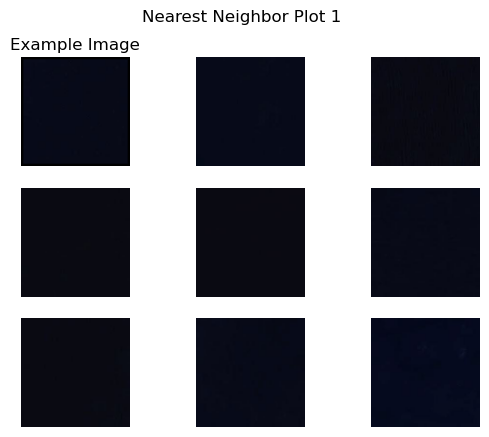

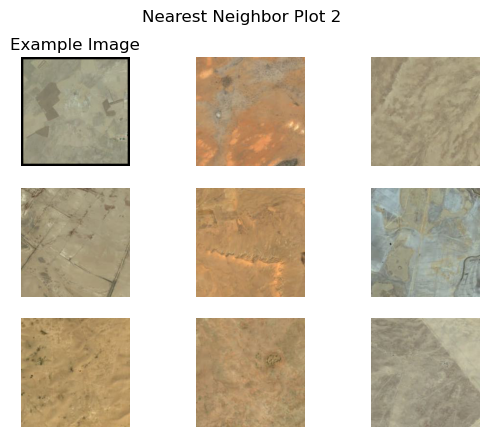

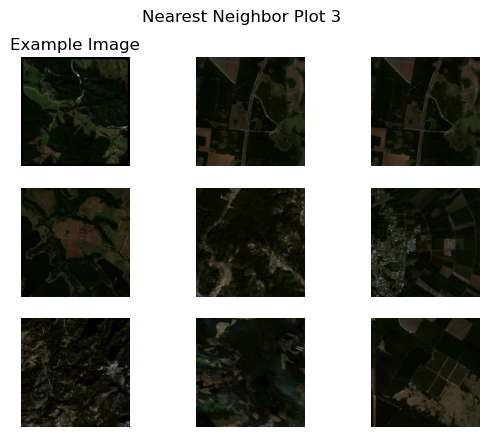

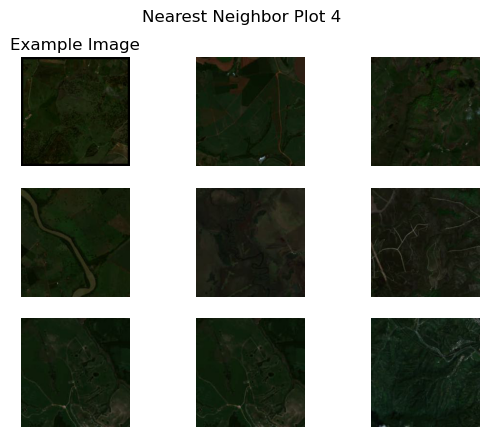

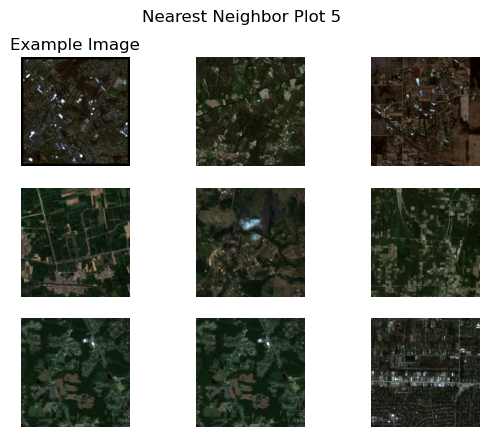

In [58]:
# show example images for each cluster
for i, example_image in enumerate(example_images):
    plot_nearest_neighbors_3x3(example_image, i)

#### DINO embeddings

In [76]:
model.backbone.load_state_dict(torch.load('/home/akansh-i2sc/Desktop/Study/HLCV/Why-Self-Supervision-in-Time/src/models/pre-trained_weights/resnet18_model_dino_20k_30e.pth')['resnet18_parameters'])

<All keys matched successfully>

In [77]:
embeddings = []
filenames = []

# disable gradients for faster calculations
model.eval()
with torch.no_grad():
    for i, (x, _, fnames) in enumerate(dataloader_test):
        # move the images to the gpu
        x = x.to(device)
        # embed the images with the pre-trained backbone
        y = model.backbone(x).flatten(start_dim=1)
        # store the embeddings and filenames in lists
        embeddings.append(y)
        filenames = filenames + list(fnames)

# concatenate the embeddings and convert to numpy
embeddings = torch.cat(embeddings, dim=0)
embeddings = embeddings.cpu().numpy()

In [78]:
projection = random_projection.GaussianRandomProjection(n_components=2)
embeddings_2d = projection.fit_transform(embeddings)
# normalize the embeddings to fit in the [0, 1] square
M = np.max(embeddings_2d, axis=0)
m = np.min(embeddings_2d, axis=0)
embeddings_2d = (embeddings_2d - m) / (M - m)

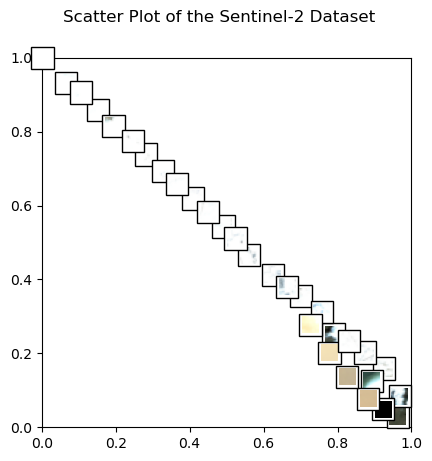

In [79]:
get_scatter_plot_with_thumbnails()

##### DINO Images

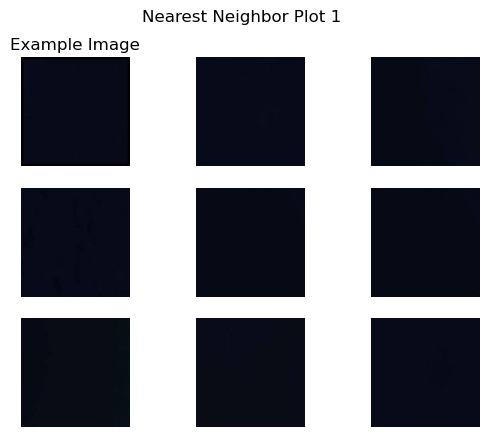

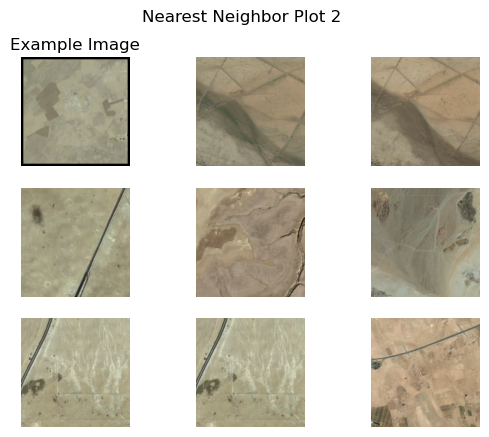

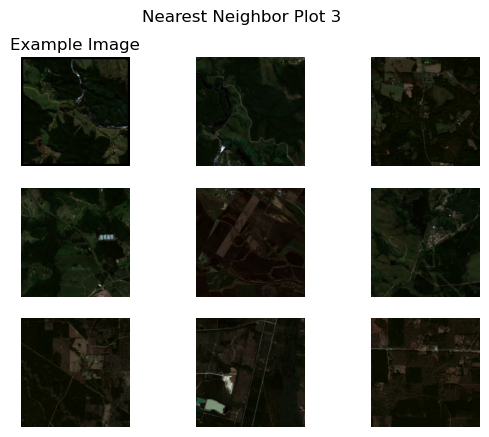

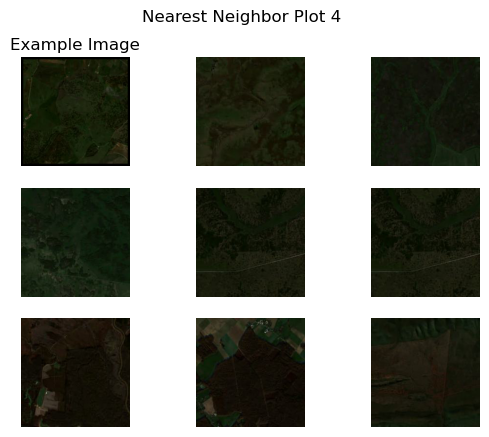

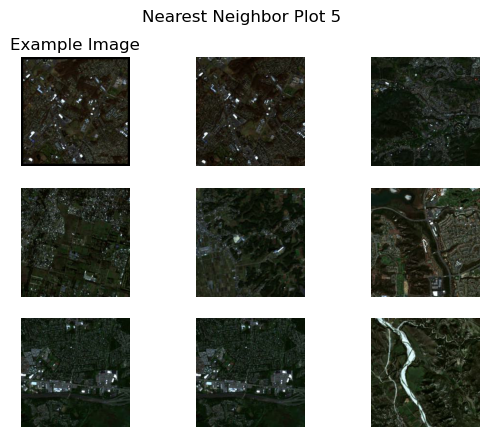

In [80]:
# show example images for each cluster
for i, example_image in enumerate(example_images):
    plot_nearest_neighbors_3x3(example_image, i)

#### ImageNet embeddings

In [81]:
resnet18_new = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1)
backbone_new = nn.Sequential(*list(resnet18_new.children())[:-1]).to(device)
embeddings = []
filenames = []

# disable gradients for faster calculations
backbone_new.eval()
with torch.no_grad():
    for i, (x, _, fnames) in enumerate(dataloader_test):
        # move the images to the gpu
        x = x.to(device)
        # embed the images with the pre-trained backbone
        y = backbone_new(x).flatten(start_dim=1)
        # store the embeddings and filenames in lists
        embeddings.append(y)
        filenames = filenames + list(fnames)

# concatenate the embeddings and convert to numpy
embeddings = torch.cat(embeddings, dim=0)
embeddings = embeddings.cpu().numpy()

projection = random_projection.GaussianRandomProjection(n_components=2)
embeddings_2d = projection.fit_transform(embeddings)
# normalize the embeddings to fit in the [0, 1] square
M = np.max(embeddings_2d, axis=0)
m = np.min(embeddings_2d, axis=0)
embeddings_2d = (embeddings_2d - m) / (M - m)

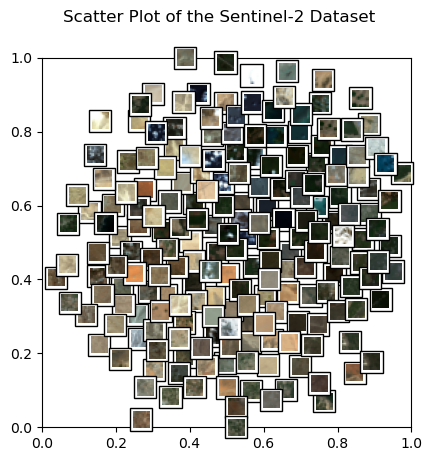

In [84]:
get_scatter_plot_with_thumbnails()

In [87]:
resnet18_new = torchvision.models.resnet18(weights=None)
backbone_new = nn.Sequential(*list(resnet18_new.children())[:-1]).to(device)
embeddings = []
filenames = []

# disable gradients for faster calculations
backbone_new.eval()
with torch.no_grad():
    for i, (x, _, fnames) in enumerate(dataloader_test):
        # move the images to the gpu
        x = x.to(device)
        # embed the images with the pre-trained backbone
        y = backbone_new(x).flatten(start_dim=1)
        # store the embeddings and filenames in lists
        embeddings.append(y)
        filenames = filenames + list(fnames)

# concatenate the embeddings and convert to numpy
embeddings = torch.cat(embeddings, dim=0)
embeddings = embeddings.cpu().numpy()

projection = random_projection.GaussianRandomProjection(n_components=2)
embeddings_2d = projection.fit_transform(embeddings)
# normalize the embeddings to fit in the [0, 1] square
M = np.max(embeddings_2d, axis=0)
m = np.min(embeddings_2d, axis=0)
embeddings_2d = (embeddings_2d - m) / (M - m)

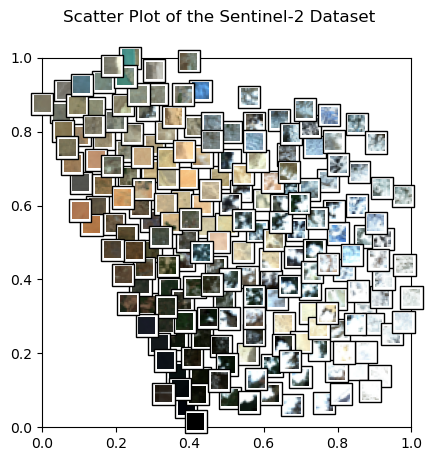

In [88]:
get_scatter_plot_with_thumbnails()

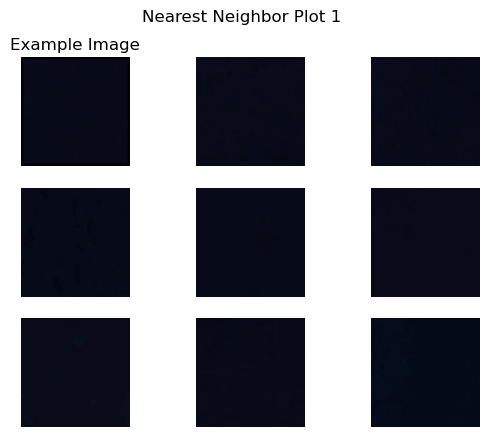

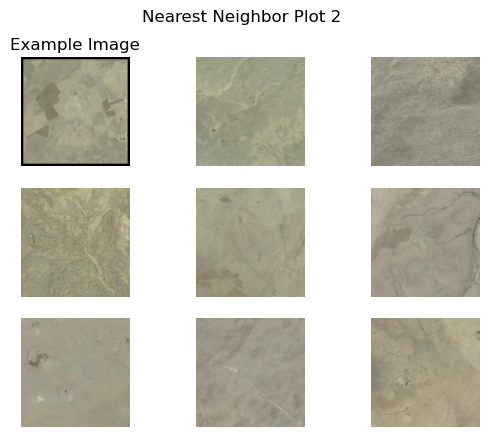

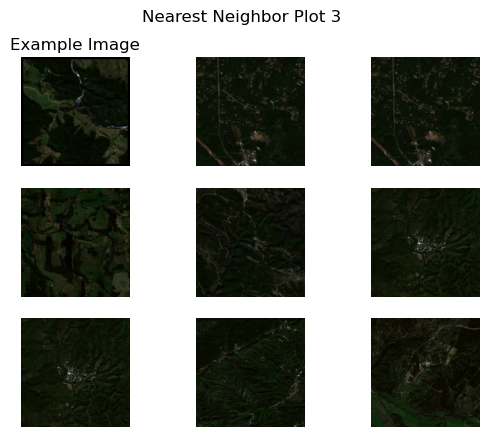

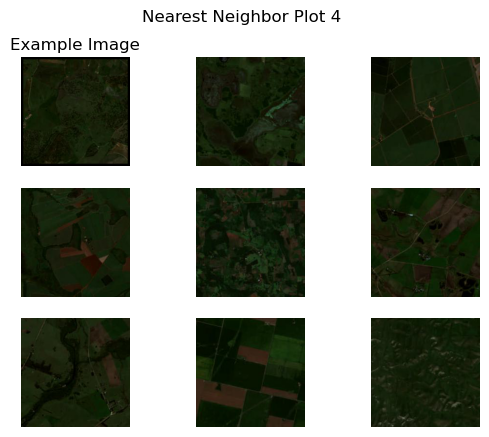

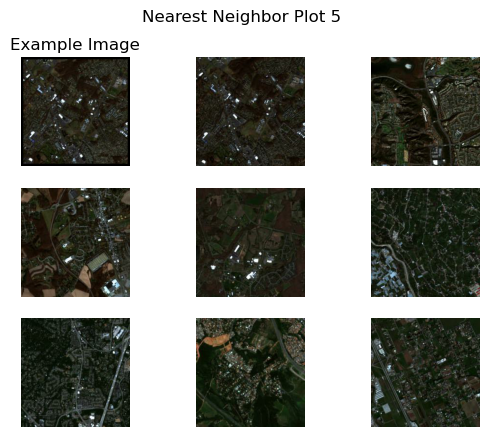

In [89]:
# show example images for each cluster
for i, example_image in enumerate(example_images):
    plot_nearest_neighbors_3x3(example_image, i)